In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from daart.data import DataGenerator
from daart.eval import get_precision_recall, plot_training_curves
from daart.models import Segmenter
from daart.transforms import ZScore

### define data paths

In [2]:
expt_id = '2019_06_26_fly2'

base_dir = '/media/mattw/fly/behavior'
# DLC markers
markers_file = os.path.join(base_dir, 'labels', expt_id + '_labeled.h5')
# heuristic labels
labels_file = os.path.join(
    base_dir, 'segmentation', 'states-v3', expt_id + '_beh-states-heuristic.pkl')
# hand labels
hand_labels_file = os.path.join(
    base_dir, 'labels_deepethogram', 'DATA', expt_id, expt_id + '_labels.csv')
# where model results will be saved
model_save_path = '/media/mattw/fly/behavior/daart-demo'

### build data generator

In [3]:
# define data generator signals
signals = ['markers', 'labels_weak']
transforms = [ZScore(), None]
paths = [markers_file, labels_file]
device = 'cuda'  # 'cpu' | 'cuda'

trial_splits = {
    'train_tr': 9,
    'val_tr': 1,
    'test_tr': 0,
    'gap_tr': 0
}

# build data generator
data_gen = DataGenerator(
    [expt_id], [signals], [transforms], [paths], device=device, batch_size=500, 
    trial_splits=trial_splits)
print(data_gen)

Generator contains 1 SingleDataset objects:
2019_06_26_fly2
    signals: ['markers', 'labels_weak']
    transforms: OrderedDict([('markers', ZScore()), ('labels_weak', None)])
    paths: OrderedDict([('markers', '/media/mattw/fly/behavior/labels/2019_06_26_fly2_labeled.h5'), ('labels_weak', '/media/mattw/fly/behavior/segmentation/states-v3/2019_06_26_fly2_beh-states-heuristic.pkl')])



In [4]:
# see what data generator returns
data, dataset = data_gen.next_batch('train')
print(data['batch_idx'])
print(data['markers'].shape)
print(data['labels_weak'].shape)

tensor([64], device='cuda:0')
torch.Size([1, 500, 16])
torch.Size([1, 500])


### build model

In [5]:
# define model params
hparams = {
    'model_type': 'temporal-mlp',
    'input_size': 16,       # dimensionality of markers
    'output_size': 5,       # number of classes
    'n_hid_layers': 1,      # hidden layers in network
    'n_hid_units': 32,      # hidden units per hidden layer
    'n_lags': 16,           # half-width of temporal convolution window
    'activation': 'relu',   # layer nonlinearity
    'lambda_weak': 1,       # hyperparam on classifying weak (heuristic) labels
    'lambda_strong': 0,     # hyperparam on classifying strong (hand) labels
    'lambda_pred': 0        # hyperparam on one-step-ahead prediction
}

# build model
model = Segmenter(hparams)
model.to(device)
print(model)


TemporalMLP architecture
------------------------
Encoder:
    0: Conv1d(16, 32, kernel_size=(33,), stride=(1,), padding=(16,))
    1: ReLU()
    2: Linear(in_features=32, out_features=32, bias=True)
Classifier:
    0: Linear(in_features=32, out_features=5, bias=True)



### train model

100%|██████████| 101/101 [00:24<00:00,  4.14it/s]


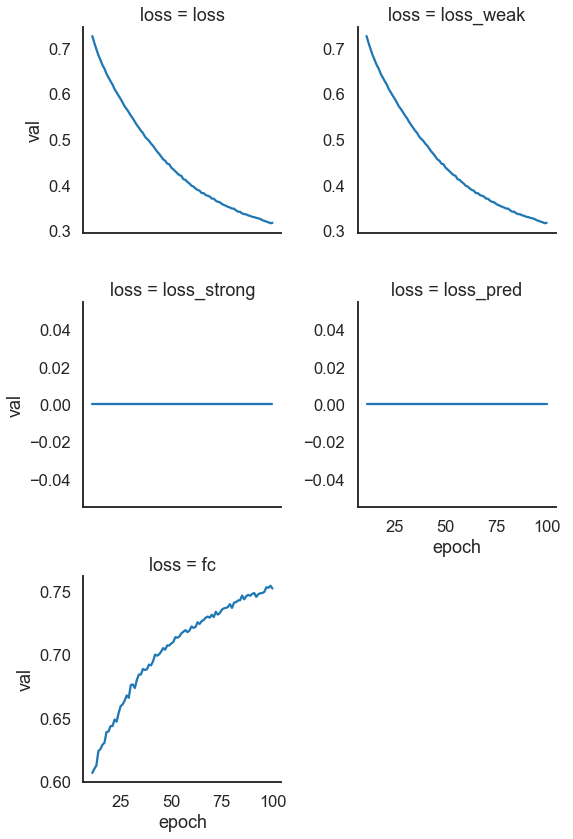

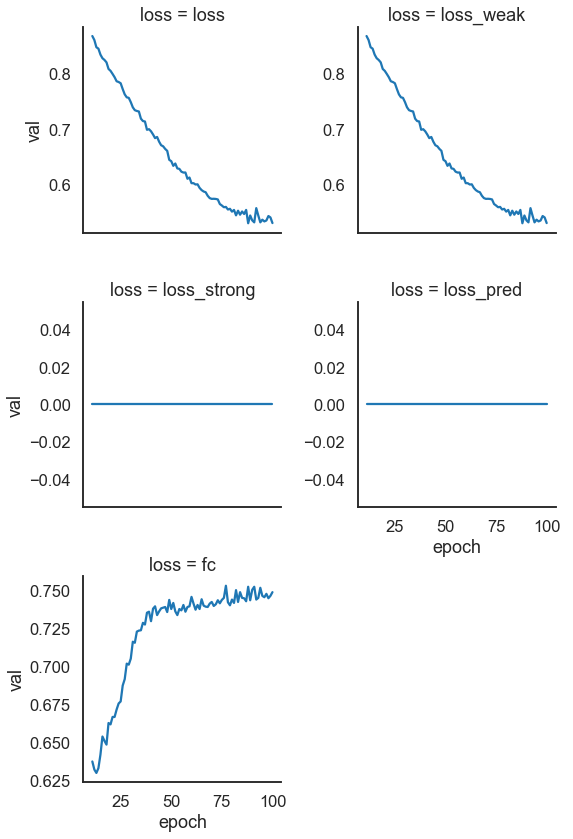

In [6]:
# define training params
train_kwargs = {
    'learning_rate': 1e-4,  # adam learning rate
    'l2_reg': 0,  # general l2 reg on parameters
    'min_epochs': 1,  # minimum number of training epochs
    'max_epochs': 100,  # maximum number of training epochs
    'val_check_interval': 1,  # requency with which to log performance on val data
    'rng_seed_train': 0,  # control order in which data are served to model
    'enable_early_stop': False,  # True to use early stopping; False will use max_epochs
    'early_stop_history': 10,  # epochs over which to average early stopping metric
    'save_last_model': False,  # true to save out last (as well as best) model
}

# fit model!
model.fit(data_gen, save_path=model_save_path, **train_kwargs)

# save training curves
plot_training_curves(
    os.path.join(model_save_path, 'metrics.csv'), dtype='train', 
    save_file=os.path.join(model_save_path, 'train_curves'), format='png')
plot_training_curves(
    os.path.join(model_save_path, 'metrics.csv'), dtype='val', 
    save_file=os.path.join(model_save_path, 'val_curves'), format='png')

### evaluate model

In [7]:
# load hand labels
from numpy import genfromtxt
labels = genfromtxt(hand_labels_file, delimiter=',', dtype=np.int, encoding=None)
labels = labels[1:, 1:]  # get rid of headers, etc.
states = np.argmax(labels, axis=1)

# get model predictions for each time point
predictions = model.predict_labels(data_gen)['labels']

# compute precision and recall for each behavior type
scores = get_precision_recall(
    states, np.argmax(np.vstack(predictions[0]), axis=1), background=0)

### plot results

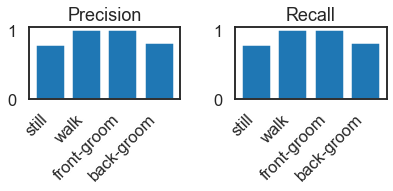

In [8]:
class_names = ['still', 'walk', 'front-groom', 'back-groom']
n_classes = len(class_names)

# get rid of background class
if len(scores['precision']) != len(class_names):
    precision = scores['precision'][1:]
    recall = scores['recall'][1:]
else:
    precision = scores['precision']
    recall = scores['recall']

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].bar(np.arange(n_classes), precision)
axes[0].set_xticks(np.arange(n_classes))
axes[0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0].set_title('Precision')

axes[1].bar(np.arange(n_classes), precision)
axes[1].set_xticks(np.arange(n_classes))
axes[1].set_xticklabels(class_names, rotation=45, ha='right')
axes[1].set_title('Recall')

plt.tight_layout()
plt.show()